<a href="https://colab.research.google.com/github/YanNews2805/CalculoNumerico/blob/main/Webinar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author Linkedin: https://www.linkedin.com/in/yanniehueseggers/

These datasets were provided by https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast

# **Walmart Sales Forecast**

**Main Question**: *Can we predict the amount of weekly sales per department store at any time of the year?*

**Answer:** *Yes, with a WMAPE of 8%*.

In this solution we are going to address three main topics:

1. Data Analysis;
2. Feature Engineering;
3. Models.

## **Functions**

### **Aggregate**

In [1]:
def agg (column1, column2):
  """
    Aggregates the given DataFrame `df` by `column1`, and sums the values of `column2`.
    Then sorts the resulting DataFrame by the values in `column2` in ascending order, with missing
    values placed at the end, and resets the index.
    
    Args:
    - column1: Column to groupby and aggregate on
    - column2: Column to sum and sort by
    
    Returns:
    - agg: A new Pandas DataFrame with aggregated and sorted values
    """
  agg = df.groupby([column1])[column2].sum().reset_index()
  agg = agg.sort_values(by=column2, ascending=True, na_position='last', ignore_index=True)
  return agg

### **Barplot**

In [2]:
def barplot (x, y):
  """
  Creates a bar plot of the average values of `y` per category of `x`.
  
  Args:
  - x: Column to groupby and plot on the x-axis
  - y: Column to calculate the average of and plot on the y-axis
  
  Returns:
  - None (displays a plot)
  """
  # Calculate the average `y` per category of `x`
  mean_y_by_x = df.groupby(x)[y].mean()
  
  # Sort the categories of `x` by the average `y`
  ordered_categories = mean_y_by_x.sort_values().index
  
  # Create the bar plot
  plt.figure(figsize=(20,8))
  sns.barplot(x=x, y=y, data=df, order=ordered_categories)
  
  # Add title, labels, and grid
  plt.title(f'Average {y} per {x}', fontsize=18)
  plt.ylabel(f'{y}', fontsize=16)
  plt.xlabel(f'{x}', fontsize=16)
  plt.grid()
  
  # Display the plot
  plt.show()

### **Model predict**

In [3]:
def model(model, X_train, y_train, X_test):
  """
  Trains a machine learning `model` on the `X_train` and `y_train` data and uses it to predict labels for `X_test`.

  Args:
  - model: a machine learning model instance with a `fit()` and `predict()` method
  - X_train: training feature data
  - y_train: training label data
  - X_test: test feature data
  
  Returns:
  - y_pred: predicted labels for the test data
  """
  
  # Setting the model
  classifier = model

  # Fitting the model to the training data
  classifier.fit(X_train, y_train)

  # Making predictions on the test data
  y_pred = classifier.predict(X_test)

  # Return the predicted labels for the test data
  return y_pred

### **Model evaluation**

In [4]:
def wmape(y_test, y_pred):
  """
  Calculates the Weighted Mean Absolute Percentage Error (WMAPE) between `y_test` and `y_pred`.
  
  Args:
  - y_test: actual labels for the test data
  - y_pred: predicted labels for the test data
  
  Returns:
  - wmape: the calculated WMAPE, expressed as a percentage
  """
  
  # Defining the score function
  wmape = np.abs(y_test - y_pred).sum() / np.abs(y_test).sum()
  
  # Return the calculated WMAPE, expressed as a percentage
  return wmape*100

## **1. Data Analysis**

### **Loading libraries and data**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats                     
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import datetime as dt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Defining the directories
root = '/content/drive/MyDrive/Webinar/'
train = 'train.csv'
features = 'features.csv'
stores = 'stores.csv'

In [8]:
# Loading data
df_train = pd.read_csv(root + train)
df_stores = pd.read_csv(root + stores)
df_features = pd.read_csv(root + features)

### **Data Overview**

In [9]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [10]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [11]:
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [12]:
print(f'\n Train dimensions:{df_train.shape} \n Stores dimensions: {df_stores.shape} \n Features dimensions:{df_features.shape}')


 Train dimensions:(421570, 5) 
 Stores dimensions: (45, 3) 
 Features dimensions:(8190, 12)


In [13]:
# Merging the features and stores dataset to the train dataset
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner') \
             .merge(df_stores, on=['Store'], how='inner')

### **Reducing The Number Of Departments**

In [14]:
dept = agg('Dept', 'Weekly_Sales')
dept

,Dept,Weekly_Sales
0,47,-4.962930e+03
1,43,1.432000e+01
2,39,1.779800e+02
3,78,1.714710e+03
4,51,3.057283e+04
...,...,...
76,90,2.910685e+08
77,72,3.057252e+08
78,38,3.931181e+08
79,95,4.493202e+08


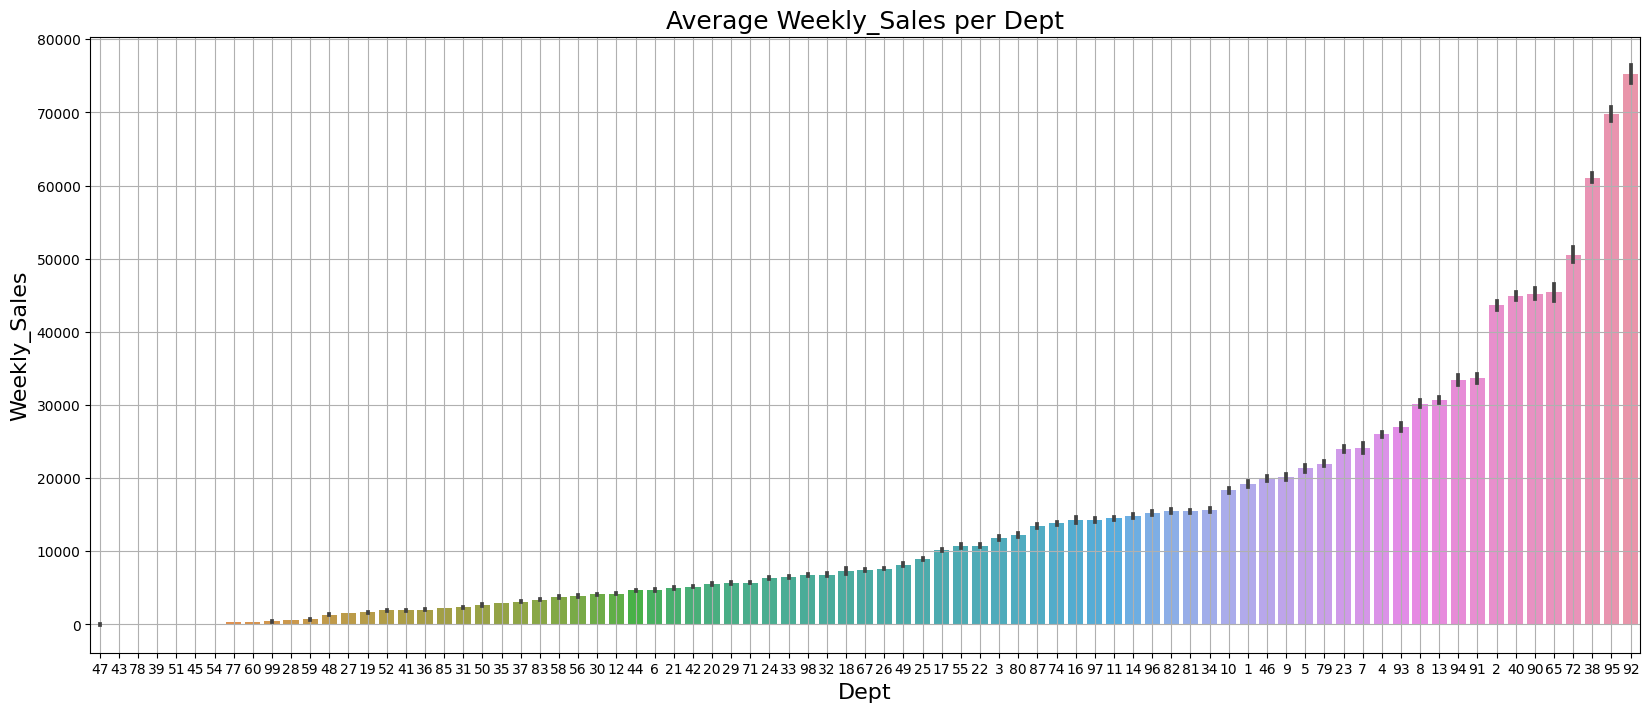

In [15]:
barplot('Dept', 'Weekly_Sales')

- Picking just the top 10 departments

In [16]:
df.shape

(421570, 17)

In [17]:
# Picking the top 10 departments
list_departament = dept['Dept'][71:]
df = df.query("Dept in @list_departament")

In [18]:
df.shape

(63961, 17)

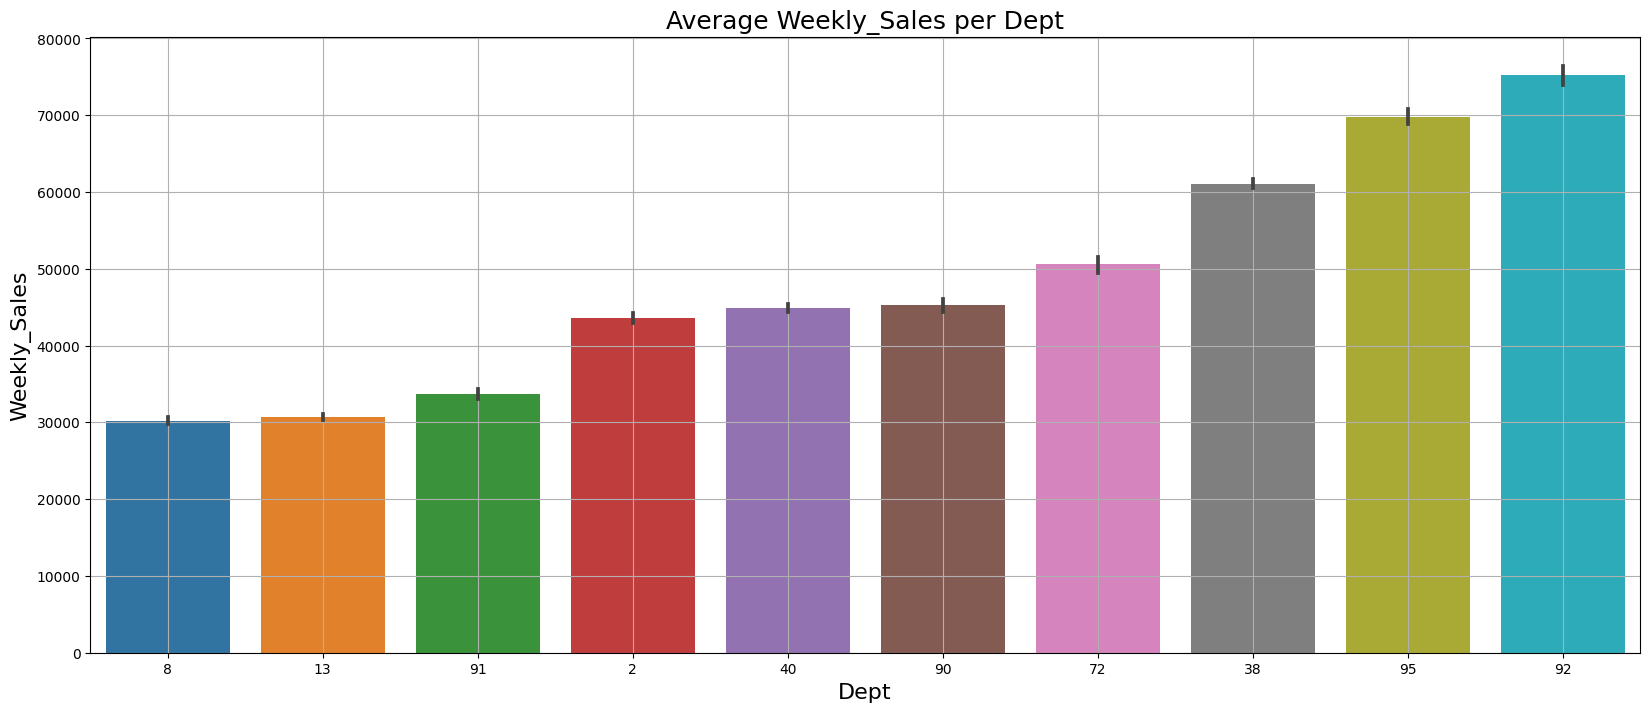

In [19]:
barplot('Dept', 'Weekly_Sales')

In [20]:
# Removing the duplicated column
df.drop(['IsHoliday_y'], axis=1,inplace=True) 

### **Numerical variables**

In [21]:
# Obtaining more detailed information about numerical features
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,63961.000000,63961.000000,63961.000000,63961.000000,63961.000000,22676.000000,16322.000000,20392.000000,19628.000000,22820.000000,63961.000000,63961.000000,63961.000000
mean,22.916230,53.991135,48484.334361,60.582108,3.358178,6891.142308,3227.179090,1354.313630,3307.512821,4452.374075,171.656540,7.997331,130838.007911
std,12.978839,36.231161,34824.137368,18.438009,0.458775,8189.797883,9277.826015,9300.347094,6212.300103,5877.199584,39.331624,1.880015,62907.159423
min,1.000000,2.000000,-379.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,12.000000,13.000000,23866.980000,47.310000,2.932000,1763.130000,37.200000,4.700000,485.200000,1709.970000,131.824290,6.891000,70713.000000
50%,23.000000,40.000000,42368.970000,62.620000,3.445000,5015.300000,188.600000,22.920000,1425.650000,3204.720000,182.658578,7.874000,126512.000000
75%,34.000000,91.000000,64822.490000,74.850000,3.735000,8901.340000,1802.840000,100.000000,3498.460000,5437.930000,212.757850,8.622000,202307.000000
max,45.000000,95.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


**Analysis output:**
*   Weekly_Sales have negative values;
*   MarkDowns have a lot of null numbers.



#### **Missing Values**

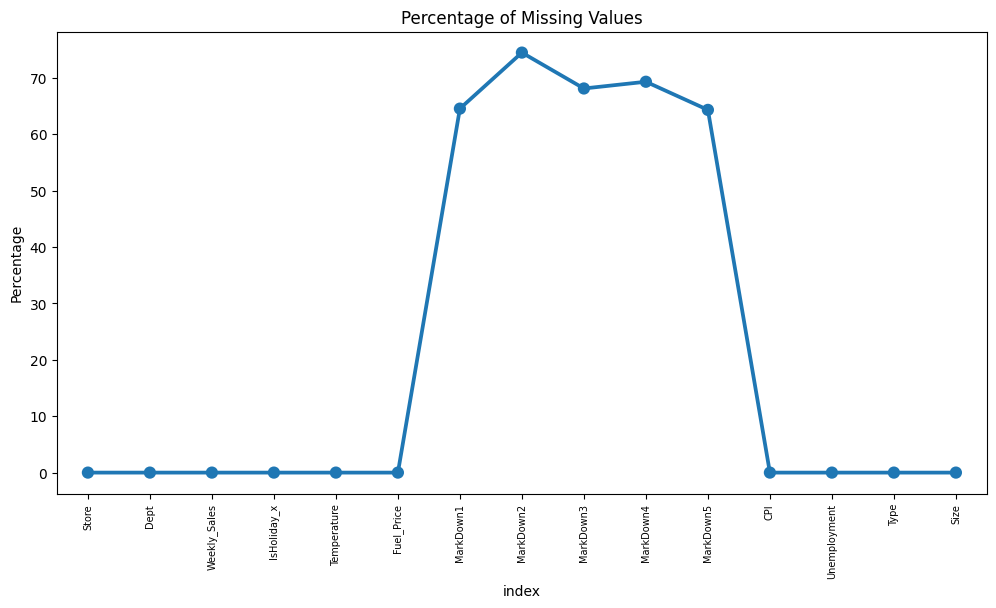

In [22]:
# Creating a dataframe with the percentage of missing values in each feature
missing = pd.DataFrame((df.drop('Date', axis=1).isnull().sum()) * 100 / df.shape[0]).reset_index()

# Plotting the dataframe graph (missing values percentage x feature)  
plt.figure(figsize=(12, 6))
ax = sns.pointplot(x='index', y=0, data=missing)
plt.xticks(rotation=90, fontsize=7)
plt.title("Percentage of Missing Values")
plt.ylabel("Percentage")
plt.show()

**Analysis output:**

*   As expected, the Markdowns feature has a lot of missing values because we do not have such promotions every week of the year.

#### **Understanding unsual data**

In [23]:
# Find the average of weekly_sales by department for each store
sales_grouped_dept = df.groupby(["Store","Dept"]).agg({'Weekly_Sales':'mean'})

# Check out negative values
neg_sales = sales_grouped_dept.query("Weekly_Sales < 0").reset_index()

# Extracting the departments numbers
dept_numbers = neg_sales[["Store", "Dept"]]
neg_sales

,Store,Dept,Weekly_Sales
0,36,72,-27.646364
1,42,72,-43.211786


**Analysis output:**
*  Only department 72 have negative weekly sales;
*  We cannot discard these values ​​or change them to zero, because we don't know what they really mean.



#### **Preparing Data for Analysis**

In [24]:
# Checking the first and last datetime
print(f'Start: {df["Date"].min()}, End: {df["Date"].max()}')

Start: 2010-02-05, End: 2012-10-26


In [25]:
# Transforming to the pandas datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['Date'],inplace=True)

In [26]:
# Creating year, month and week features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.week

df.head()

<ipython-input-26-1f71e2c953ba>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['Week'] = df['Date'].dt.week


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Week
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,5
340321,36,95,2010-02-05,40389.37,False,45.97,2.545,NaN,NaN,NaN,NaN,NaN,209.852966,8.554,A,39910,2010,2,5
340318,36,92,2010-02-05,63964.12,False,45.97,2.545,NaN,NaN,NaN,NaN,NaN,209.852966,8.554,A,39910,2010,2,5
340317,36,91,2010-02-05,11509.78,False,45.97,2.545,NaN,NaN,NaN,NaN,NaN,209.852966,8.554,A,39910,2010,2,5
340316,36,90,2010-02-05,47158.21,False,45.97,2.545,NaN,NaN,NaN,NaN,NaN,209.852966,8.554,A,39910,2010,2,5


### **Analysis of the Number of Sales**

#### **Per Year**

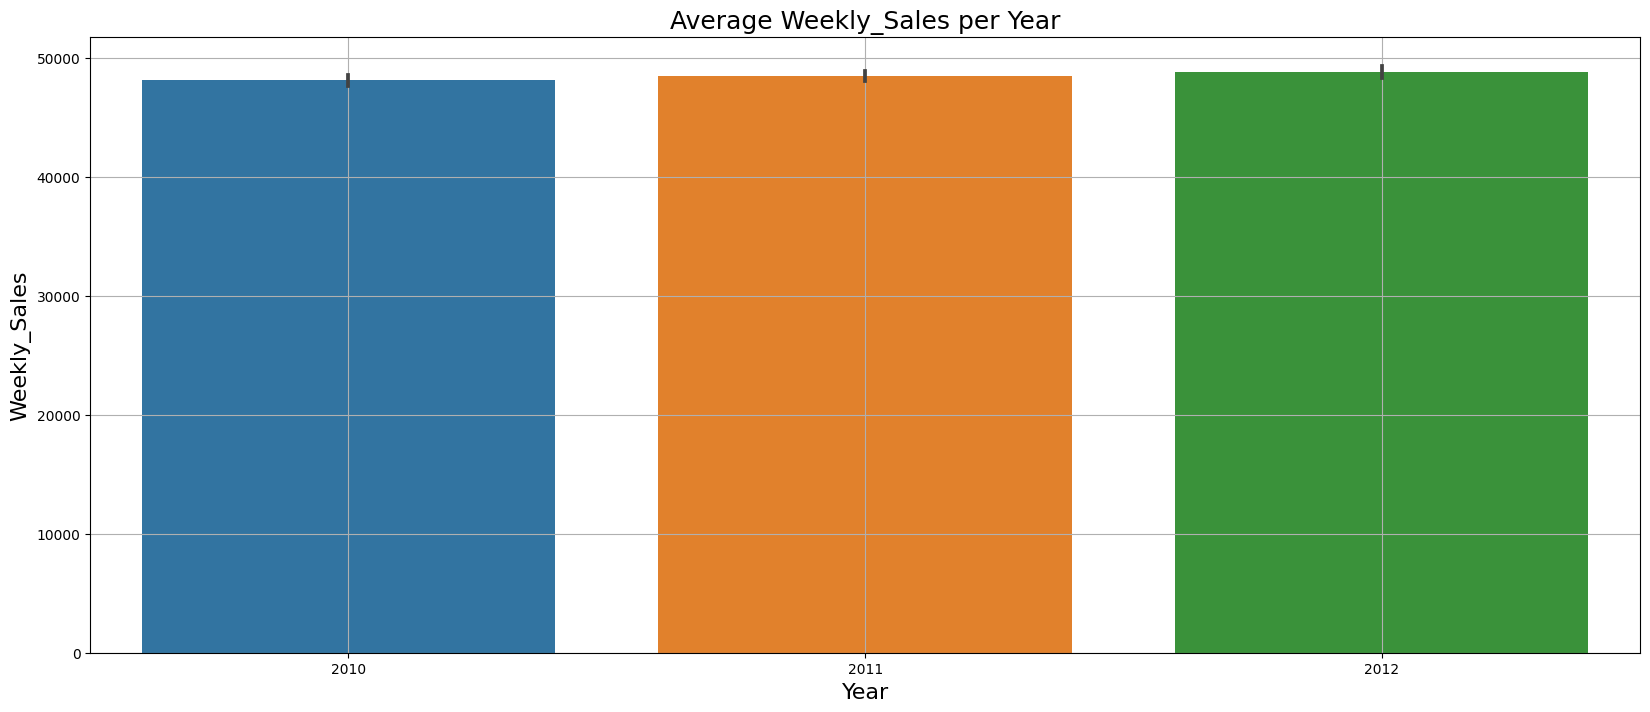

In [27]:
agg('Year', 'Weekly_Sales')
barplot('Year', 'Weekly_Sales')

**Analysis output:**
*   2012 was the best sales year;
*   2010 was the worst sales year.




#### **Per Month**

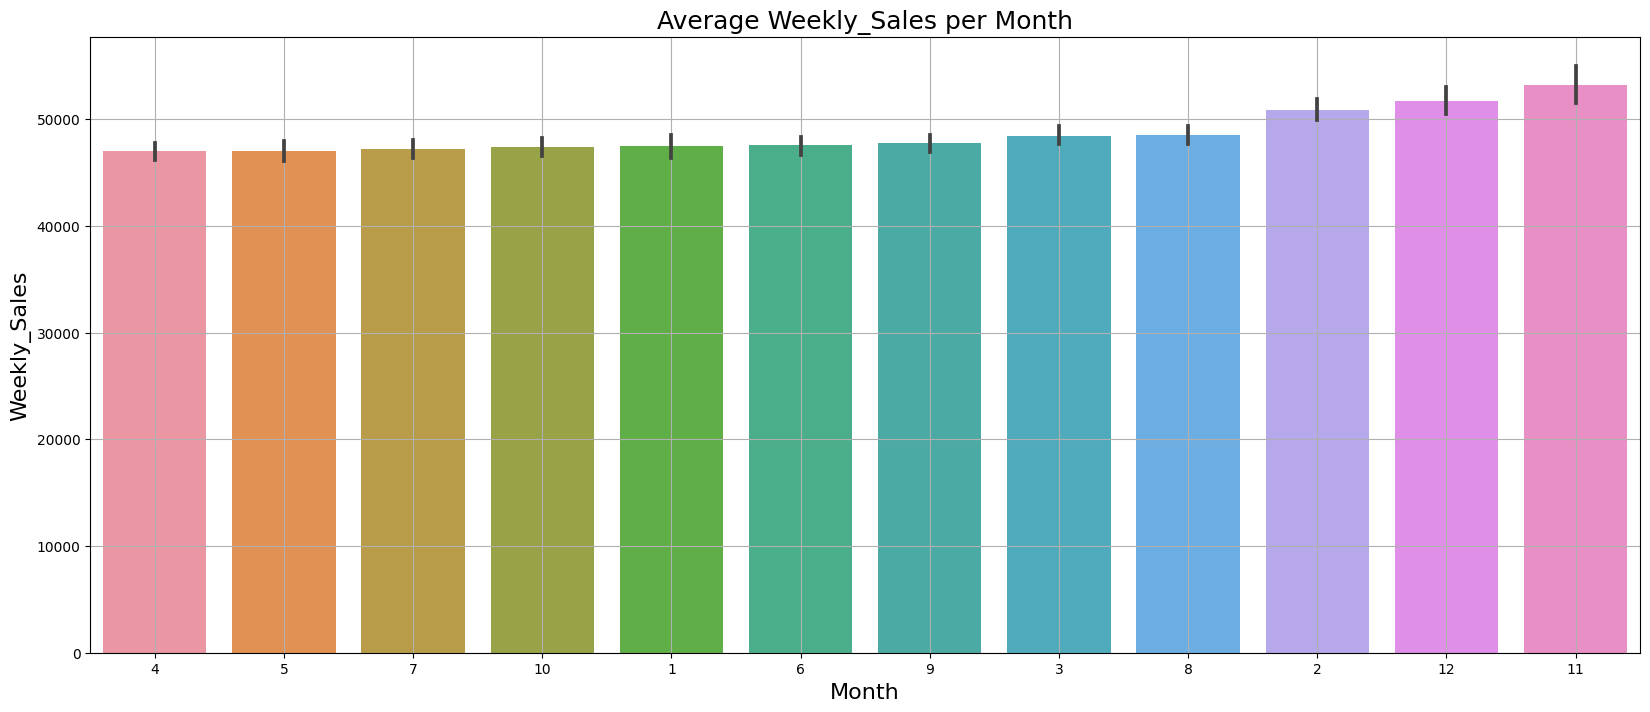

In [28]:
agg('Month', 'Weekly_Sales')
barplot('Month', 'Weekly_Sales')

**Analysis output:**
* The top 3 months in descending order:
  - 11, 12 and 2
* The 3 worst months in ascending order:
  - 4, 5 and 7.



#### **Per Store**

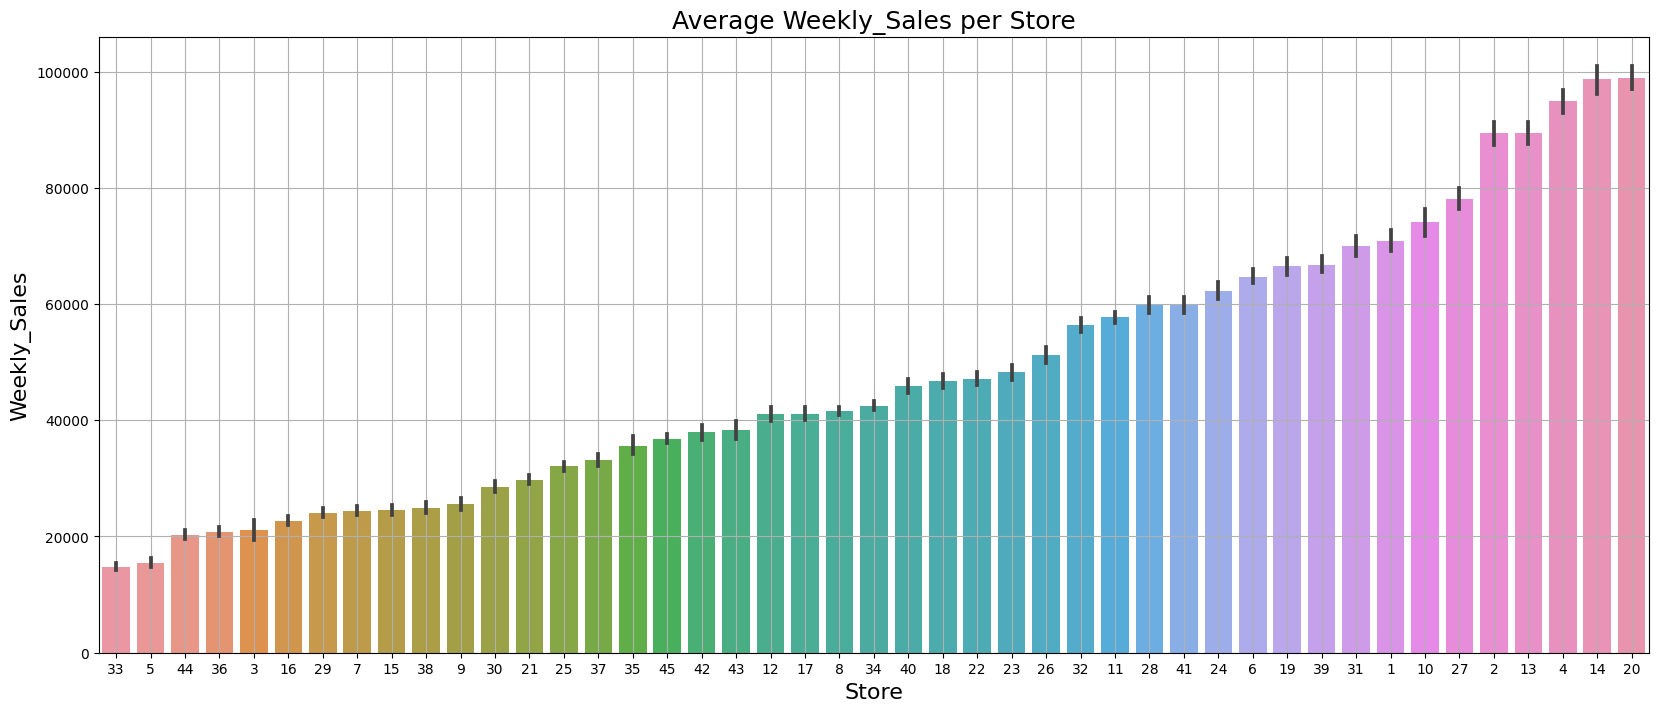

In [29]:
agg('Store', 'Weekly_Sales')
barplot('Store', 'Weekly_Sales')

**Analysis output:**
* The top 3 Stores in descending order:
  - 20, 14 and 4.
* The 3 worst stores in ascending order:
  - 33, 5 and 44.



#### **Per Store Size**

In [30]:
# Plotting graph of average sales per size
sizes= df.groupby('Size').mean()
fig=px.line(sizes, x = sizes.index, y = sizes.Weekly_Sales, 
        title='Size da Store e vendas')
fig.show()

<ipython-input-30-9226120e6b0c>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sizes= df.groupby('Size').mean()


**Analysis output:**
*   Size and weekly sales are directly related.



## **2. Feature Engineering**

#### **ID**

- Each store and department combination has its own identifier.

In [31]:
# Creating the ID column
df['Dept'] = df['Dept'].astype(str)
df['Store'] = df['Store'].astype(str)
df['ID'] = df['Store'] + '_' + df['Dept']

In [32]:
df['ID'] = df['Store'].astype(str) + '_' + df['Dept'].astype(str)

In [33]:
df['Dept'] = df['Dept'].astype(int)
df['Store'] = df['Store'].astype(int)

**ID format:** Store_Department 

**Ex:** 1_45

In [34]:
# Transforming the Date colum in the dataframe index
df['Date'] = pd.to_datetime(df['Date'],errors='coerce')
df.sort_values(by=['ID','Date'],inplace=True)
df.set_index(df.Date, inplace=True)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Week,ID
Date,,,,,,,,,,,,,,,,,,,,
2010-02-05,10,13,2010-02-05,74020.63,False,54.34,2.962,NaN,NaN,NaN,NaN,NaN,126.442065,9.765,B,126512,2010,2,5,10_13
2010-02-12,10,13,2010-02-12,69145.42,True,49.96,2.828,NaN,NaN,NaN,NaN,NaN,126.496258,9.765,B,126512,2010,2,6,10_13
2010-02-19,10,13,2010-02-19,68060.96,False,58.22,2.915,NaN,NaN,NaN,NaN,NaN,126.526286,9.765,B,126512,2010,2,7,10_13
2010-02-26,10,13,2010-02-26,71517.99,False,52.77,2.825,NaN,NaN,NaN,NaN,NaN,126.552286,9.765,B,126512,2010,2,8,10_13
2010-03-05,10,13,2010-03-05,70279.43,False,55.92,2.877,NaN,NaN,NaN,NaN,NaN,126.578286,9.765,B,126512,2010,3,9,10_13


In [35]:
# Date can't be used in the model
df = df.drop('Date', axis=1)

### **Creating new features**

#### **Sales Next Week**

- Create a new column called 'Sales_Next_Week' that contains the value of 'Weekly_Sales' shifted by one row within each group defined by the 'ID' column this effectively assigns the sales value for the next week to the current week's row.

In [36]:
df['Sales_Next_Week'] = df.groupby("ID")['Weekly_Sales'].shift(-1)

In [37]:
df[['ID', 'Weekly_Sales', 'Sales_Next_Week']].head()

,ID,Weekly_Sales,Sales_Next_Week
Date,,,
2010-02-05,10_13,74020.63,69145.42
2010-02-12,10_13,69145.42,68060.96
2010-02-19,10_13,68060.96,71517.99
2010-02-26,10_13,71517.99,70279.43
2010-03-05,10_13,70279.43,67184.64


#### **Weekly Sales Difference**

- Create a new column called 'Diff_Weekly_Sales' that contains the difference between the current week's 'Weekly_Sales' and the previous week's 'Weekly_Sales' value within each group defined by the 'ID' column.

In [38]:
#Calculating the difference in percentage between the actual week and the next week sales
df['Diff_Weekly_Sales'] = (df.groupby(['ID'])['Weekly_Sales'].diff() / df['Weekly_Sales']) * 100

In [39]:
df[['ID', 'Weekly_Sales', 'Diff_Weekly_Sales']].head()

,ID,Weekly_Sales,Diff_Weekly_Sales
Date,,,
2010-02-05,10_13,74020.63,NaN
2010-02-12,10_13,69145.42,-7.050662
2010-02-19,10_13,68060.96,-1.593366
2010-02-26,10_13,71517.99,4.833791
2010-03-05,10_13,70279.43,-1.762336


##### **Feature Validation**

- Checking if the created variable does what it needs to.

In [40]:
((df['Weekly_Sales'][1] - df['Weekly_Sales'][0]) /df['Weekly_Sales'][1]) * 100

-7.05066221305765

In [41]:
((df['Weekly_Sales'][100] - df['Weekly_Sales'][99]) / df['Weekly_Sales'][100]) * 100

17.51943138572091

In [42]:
df['Diff_Weekly_Sales'][100]

17.51943138572091

**DDiff_Weekly_Sales calculation:** Actual Week Sales - Last Week Sales

#### **Average Last Four Weeks Sales**

- Create a new column called 'AVG_Last4Weeks_Sales' that contains the rolling average of the previous four weeks' 'Weekly_Sales' values within each group defined by the 'ID' column;
- The rolling average is calculated using the 'rolling' method with a window size of 4;
- We then reset the index to the original order and drop the redundant index created by the rolling method.

In [43]:
# Calculating the month sales per department
df['AVG_Last4Weeks_Sales'] = df.groupby('ID')['Weekly_Sales'].rolling(4).mean().reset_index(level=0,drop=True)

**AVG_Month_Sales calculation:** Average of the Weekly_Sales of the last four weeks 

In [44]:
df[['ID', 'Weekly_Sales', 'AVG_Last4Weeks_Sales']].head()

,ID,Weekly_Sales,AVG_Last4Weeks_Sales
Date,,,
2010-02-05,10_13,74020.63,NaN
2010-02-12,10_13,69145.42,NaN
2010-02-19,10_13,68060.96,NaN
2010-02-26,10_13,71517.99,70686.25
2010-03-05,10_13,70279.43,69750.95


##### **Feature Validation**
- Checking if the created variable does what it needs to.

In [45]:
(df['Weekly_Sales'][0] + df['Weekly_Sales'][1] + df['Weekly_Sales'][2] + df['Weekly_Sales'][3]) / 4

70686.25

In [46]:
(df['Weekly_Sales'][150] + df['Weekly_Sales'][149] + df['Weekly_Sales'][148] + df['Weekly_Sales'][147]) / 4

113193.48500000002

In [47]:
df['AVG_Last4Weeks_Sales'][150]

113193.485

### **Handling Missing Data**

The features:
- Sales_Next_Week
- AVG_Last4Weeks_Sales
- Diff_Weekly_Sales


They will have missing values ​​as they use previous rows to be calculated. Knowing that in the first timestamp we have no previous values, so take np.nan.

So to fix that, let's fill it in with the average value of each column.

In [48]:
mkdown = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
# fill NaN values with 0
df[mkdown] = df[mkdown].fillna(0)

In [49]:
# Filling with the mean value for Sales Next Week and Average Last Fours Weeks Sales
next_and_month = ['Sales_Next_Week', 'AVG_Last4Weeks_Sales', 'Diff_Weekly_Sales']
df[next_and_month] = df[next_and_month].fillna(df[next_and_month].mean())

In [50]:
# We can't use ID in the model
df = df.drop(['Store', 'Dept', 'ID'],axis=1)

### **Feature Encoding**

Converting categorical or text data into numerical values that machine learning algorithms can use to make predictions

In [51]:
# Finding all the categorical features
categorical_cols = [col for col in df.select_dtypes(include=['category', 'object','bool']).columns]

In [52]:
categorical_cols

['IsHoliday_x', 'Type']

In [53]:
# Encoding the categorical features
df = pd.get_dummies(df,columns=categorical_cols)

In [54]:
df.head()

,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,Month,Week,Sales_Next_Week,Diff_Weekly_Sales,AVG_Last4Weeks_Sales,IsHoliday_x_False,IsHoliday_x_True,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,74020.63,54.34,2.962,0.0,0.0,0.0,0.0,0.0,126.442065,9.765,...,2,5,69145.42,-1.626246,48457.182518,1,0,0,1,0
2010-02-12,69145.42,49.96,2.828,0.0,0.0,0.0,0.0,0.0,126.496258,9.765,...,2,6,68060.96,-7.050662,48457.182518,0,1,0,1,0
2010-02-19,68060.96,58.22,2.915,0.0,0.0,0.0,0.0,0.0,126.526286,9.765,...,2,7,71517.99,-1.593366,48457.182518,1,0,0,1,0
2010-02-26,71517.99,52.77,2.825,0.0,0.0,0.0,0.0,0.0,126.552286,9.765,...,2,8,70279.43,4.833791,70686.250000,1,0,0,1,0
2010-03-05,70279.43,55.92,2.877,0.0,0.0,0.0,0.0,0.0,126.578286,9.765,...,3,9,67184.64,-1.762336,69750.950000,1,0,0,1,0


### **Correlation with Next Week Sales**

In [55]:
# Calculate the correlation between variables and weekly sales
next_week_correlation_matrix = df.corr().iloc[14,:]

# Convert the correlation matrix to a sorted dataframe
correlation_df = pd.DataFrame(data=next_week_correlation_matrix, 
                              index=next_week_correlation_matrix.index)\
                  .sort_values(by='Sales_Next_Week', ascending=False)

# Remove the first row (which represents the correlation of weekly sales with itself)
correlation_df = correlation_df.iloc[1:]

# Plot a bar chart to visualize the correlation between variables and next week sales
figure = px.bar(correlation_df, x=correlation_df.index, y='Sales_Next_Week', 
                color=correlation_df.index, 
                labels={'index':'Features'}, 
                title='Correlation of variables with next week sales')

# Hide the legend on the chart
figure.update_traces(showlegend=False)
fig.update_layout(uniformtext_minsize=6, uniformtext_mode='hide')
# Display the chart
figure.show()

**Analysis output:**

- The last four weeks and weekly sales have a high correlation with next week's sales;
- Size and type are also very important features.



### **Preparing Data**

- Sort the dataset for date;
- Create the train and test dataset;
- Create the train and test variables.

In [56]:
# Sorting only by date
df.sort_values(by=['Date'],inplace=True)

In [57]:
# Creating the top five features dataset
train = df
train['Sales_Next_Week'] = df['Sales_Next_Week']

In [58]:
# Dividing 70% of the timestamp to train and 15% to val and 15% to test
train = train.loc[: pd.Timestamp('2012-01-06')]

In [59]:
train

,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,Month,Week,Sales_Next_Week,Diff_Weekly_Sales,AVG_Last4Weeks_Sales,IsHoliday_x_False,IsHoliday_x_True,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,74020.63,54.34,2.962,0.00,0.00,0.00,0.00,0.00,126.442065,9.765,...,2,5,69145.42,-1.626246,48457.182518,1,0,0,1,0
2010-02-05,53635.06,22.43,2.954,0.00,0.00,0.00,0.00,0.00,131.527903,8.326,...,2,5,50808.32,-1.626246,48457.182518,1,0,1,0,0
2010-02-05,19437.35,19.83,2.954,0.00,0.00,0.00,0.00,0.00,131.527903,8.350,...,2,5,18775.19,-1.626246,48457.182518,1,0,0,1,0
2010-02-05,37611.70,10.53,2.580,0.00,0.00,0.00,0.00,0.00,189.381697,9.014,...,2,5,36727.96,-1.626246,48457.182518,1,0,0,1,0
2010-02-05,119463.15,54.34,2.962,0.00,0.00,0.00,0.00,0.00,126.442065,9.765,...,2,5,111422.87,-1.626246,48457.182518,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-06,66531.81,50.82,3.157,3220.17,32056.43,108.24,985.76,6650.63,221.308802,6.132,...,1,1,66349.72,-58.992849,114654.147500,1,0,1,0,0
2012-01-06,36066.87,36.39,3.158,5998.79,18094.69,104.92,351.55,2890.32,130.157516,9.653,...,1,1,33764.91,8.834174,39251.907500,1,0,1,0,0
2012-01-06,134489.59,33.80,3.080,6809.96,37106.52,179.77,1922.55,7481.58,130.157516,6.104,...,1,1,128818.78,9.978616,144367.030000,1,0,1,0,0


In [60]:
test = df
test['Sales_Next_Week'] = df['Sales_Next_Week']

In [61]:
test = test.loc[pd.Timestamp('2012-01-13'):]

In [62]:
len(df) == len(train) + len(test)

True

In [63]:
# Creating the train and test variables
X_train = train.loc[:, train.columns != 'Sales_Next_Week']
y_train = train['Sales_Next_Week']
y_train = y_train.values.ravel()

X_test = test.loc[:, test.columns != 'Sales_Next_Week']
y_test = test['Sales_Next_Week']
y_test = y_test.values.ravel()

In [64]:
X_train

,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,Year,Month,Week,Diff_Weekly_Sales,AVG_Last4Weeks_Sales,IsHoliday_x_False,IsHoliday_x_True,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,74020.63,54.34,2.962,0.00,0.00,0.00,0.00,0.00,126.442065,9.765,...,2010,2,5,-1.626246,48457.182518,1,0,0,1,0
2010-02-05,53635.06,22.43,2.954,0.00,0.00,0.00,0.00,0.00,131.527903,8.326,...,2010,2,5,-1.626246,48457.182518,1,0,1,0,0
2010-02-05,19437.35,19.83,2.954,0.00,0.00,0.00,0.00,0.00,131.527903,8.350,...,2010,2,5,-1.626246,48457.182518,1,0,0,1,0
2010-02-05,37611.70,10.53,2.580,0.00,0.00,0.00,0.00,0.00,189.381697,9.014,...,2010,2,5,-1.626246,48457.182518,1,0,0,1,0
2010-02-05,119463.15,54.34,2.962,0.00,0.00,0.00,0.00,0.00,126.442065,9.765,...,2010,2,5,-1.626246,48457.182518,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-06,66531.81,50.82,3.157,3220.17,32056.43,108.24,985.76,6650.63,221.308802,6.132,...,2012,1,1,-58.992849,114654.147500,1,0,1,0,0
2012-01-06,36066.87,36.39,3.158,5998.79,18094.69,104.92,351.55,2890.32,130.157516,9.653,...,2012,1,1,8.834174,39251.907500,1,0,1,0,0
2012-01-06,134489.59,33.80,3.080,6809.96,37106.52,179.77,1922.55,7481.58,130.157516,6.104,...,2012,1,1,9.978616,144367.030000,1,0,1,0,0


In [65]:
y_train

array([6.9145420e+04, 5.0808320e+04, 1.8775190e+04, ..., 1.2881878e+05,
       6.4353720e+04, 1.0619000e+02])

## **3. Models**

### **Comparing models**

We are going to compare three models performance:

1. Decision Tree;
2. Random Forest;
3. XGBoost.
Using ROC_AUC as the main metric.

In [66]:
# Defining the models
trees = DecisionTreeRegressor(random_state=0)
forest = RandomForestRegressor(random_state=0)
xg = xgb.XGBRegressor(random_state=0)

#### **Baseline Model**

In [67]:
y_pred_baseline_test = test['Weekly_Sales']
y_test_baseline_test = test['Sales_Next_Week']

#### **Scoring the models**

1. **MAPE:** **M**ean **A**bsolute **P**ercentage **E**rror

 **1.1 Pros:** Easy to understand, commonly used in sales

 **1.2 Cons:** with a significant amount of zeros, the metric goes to infinity

2. **WMAPE:** (**W**eighted)**MAPE**

  **2.1 Pros:** Easy to understand, commonly used in sales

  **2.2 Pros:** with a significant amount of zeros, the metric doesn't go to infinity

For the score, we are using **WMAPE** to check the model performance in general.


### **Predictions Dataset**

In [68]:
# Including the cikumns
forest_predict = model(forest, X_train, y_train, X_test)
trees_predict = model(trees, X_train, y_train, X_test)
xgb_predict = model(xg, X_train, y_train, X_test)
baseline_predict= y_pred_baseline_test

### **Metric Results**

In [69]:
print(f' Baseline model test --> test: \n WMAPE:{wmape(y_test_baseline_test, y_pred_baseline_test)}')

 Baseline model test --> test: 
 WMAPE:8.819756942261451


In [70]:
print(f'WMAPE for train --> test:\nForest: {wmape(y_test, forest_predict)}\nTrees: {wmape(y_test, trees_predict )}\nXGB: {wmape(y_test, xgb_predict)}')

WMAPE for train --> test:
Forest: 13.36624387164359
Trees: 26.40360958265291
XGB: 16.420364331476097


### **Feature selection**

The goal of feature selection is to reduce the dimensionality of the dataset, while retaining as much relevant information as possible, in order to improve the performance of machine learning models.

In [ ]:
# Create an instance of the SelectFromModel
sel = SelectFromModel(forest)

# Fit the SelectFromModel instance to the training data.
sel.fit(X_train, y_train)

# Get a Boolean mask indicating which features were selected.
selected_mask = sel.get_support()

# Extract the names of the selected features from the training data.
selected_feat= X_train.columns[(selected_mask)]

In [ ]:
# Get the feature importances from the trained classifier
importances = forest.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Create a bar plot of the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [ ]:
print(selected_feat)

#### **Redefining the train and test features**

In [ ]:
train = train[['Weekly_Sales', 'AVG_Last4Weeks_Sales', 'Sales_Next_Week']]
test = test[['Weekly_Sales', 'AVG_Last4Weeks_Sales', 'Sales_Next_Week']]

In [ ]:
X_train = train.loc[:, train.columns != 'Sales_Next_Week']
X_test = test.loc[:, test.columns != 'Sales_Next_Week']

### **Final Result**

In [ ]:
forest_predict = model(forest, X_train, y_train, X_test)
trees_predict = model(trees, X_train, y_train, X_test)
xgb_predict = model(xg, X_train, y_train, X_test)

In [ ]:
print(f'WMAPE for train --> test:\nForest: {wmape(y_test, forest_predict)}\nTrees: {wmape(y_test, trees_predict )}\nXGB: {wmape(y_test, xgb_predict)}')

In [ ]:
final_result = round((wmape(y_test_baseline_test, y_pred_baseline_test) / wmape(y_test, xgb_predict) - 1) * 100)
print(f'Improvment of {final_result}%')

**Analysis output:**

- XGB outperforms the Baseline model on the chosen metric.

###**Comparing with the real case scenario**

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Comparison between actual and predicted next week sales',fontsize=16)
plt.plot(xgb_predict[:100], label="prediction", linewidth=3.0,color='blue')
plt.plot(y_test[:100], label="real_values", linewidth=3.0,color='red')
plt.legend(loc="best")
plt.show()

## **Next steps**

To improve our solution, we could:

*   Treat outliers;
*   Find new hyperparameters that improve our metrics;
*   Try more features with more periods.


